# Exercise 09

## Changes to the Evacuation Model

To enable exercises about stochasticity, the evacuation model has been modified:

* Isolated stochastic processes
  * *rng_propagate* for information propagation
  * *rng_placement* for placing agents in the room
  * *rng_orientation* for the agents' initial orientation
* addded `_str__` und `__repr__` function for Human and FloorObject


## Evaluation Code


In [1]:

from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(0,'../../abmodel')

from fire_evacuation.model import FireEvacuation
from fire_evacuation.agent import Human


unikcolors = [np.array((80,149,200))/255, np.array((74,172,150))/255,
                                                  np.array((234,195,114))/255, np.array((199,16,92))/255]
uniks = LinearSegmentedColormap.from_list( 'unik', unikcolors)

# Task 2 (Stochasticity in the evacuation model)

## Subtask 2 (Isolation of random processes)

There are many random processes involved in the evacuation model. To get an idea about their particular impact on the model, underlying random number streams can be isolated, i.e. for each process a separate random number stream can be used.

Boxplots are a suitable type of figure to show the variation in results. Complete the functon `plotBoxplots()` and visualise the data from simulations with varying random seed for different random processes as boxplot showing **mean** and outliers. You find hints on how to program boxplots with matplotlib at [pandas plot function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html), at [matplotlib examples](https://matplotlib.org/3.5.1/plot_types/stats/boxplot_plot.html#sphx-glr-plot-types-stats-boxplot-plot-py) and/or [this tutorial](https://machinelearningknowledge.ai/matplotlib-boxplot-tutorial-for-beginners/).

Execute the following code and discuss the results. Choose suitable values for `ylim` (consider plotting twice with different values of `ylim`). Formulate statements about the impact of each of the random processes (<250 words)! Also consider outliers!

In [2]:
# Complete the following method with the creation of boxplots:
def plotBoxplot(data=None, title="", **kwargs):
    """
    Parameters
        ----------
        data : dataFrame
            with entries "Placement", "Orientation", "Propagation" in column 'RNG' for one value of interact_moore
        title : str
    """
    # df to dict
    dict = {key: data[data['RNG']==key]['Step'].values for key in data['RNG'].unique()}
    
    for drop_outliers in [False, True]:
        # Implement boxplot 
        fig, ax = plt.subplots()
        ax.boxplot(dict.values())
        ax.set_xticklabels(dict.keys())

        # ylim outliers
        if drop_outliers:
            ax.set_ylim([max(0, min([np.percentile(dict[key], 5) for key in dict.keys()]) - 10), 2 + max([np.percentile(dict[key], 95) for key in dict.keys()])])

        # title
        plt.title(title + ' outliers dropped' if drop_outliers else title)

In [3]:
# placement seed
params = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.5,
    facilitators_percentage= 5,
    interact_moore = {0.05, 0.1, 0.4},
    seed = 0,
    seed_placement = range(0,30),
    seed_orientation = 0,
    seed_propagate = 0
)
results_placement = batch_run(
        FireEvacuation,
        parameters=params,
        iterations = 1,
        max_steps = 500,
    )

# orientation seed
params = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.5,
    facilitators_percentage= 5,
    interact_moore = {0.05, 0.1, 0.4},
    seed = 0,
    seed_placement = 0,
    seed_orientation = range(0,30),
    seed_propagate = 0
)
results_orientation = batch_run(
        FireEvacuation,
        parameters=params,
        iterations = 1,
        max_steps = 500,
    )

# propagation seed
params = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.5,
    facilitators_percentage= 5,
    interact_moore = {0.05, 0.1, 0.4},  # given moore neighbourhood, how likely is it that a human will interact with a neighbour
    seed = 0,
    seed_placement = 0,
    seed_orientation = 0,
    seed_propagate = range(0,30)    # seed for the random number generator, comparing values to moore matrix of communication
)    
results_propagate = batch_run(
        FireEvacuation,
        parameters=params,
        iterations = 1,
        max_steps = 500,
    )

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

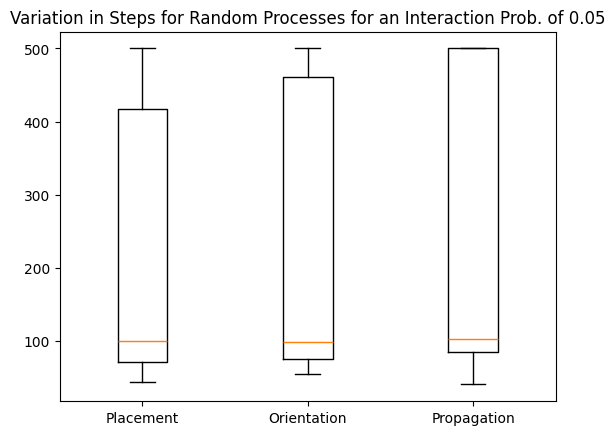

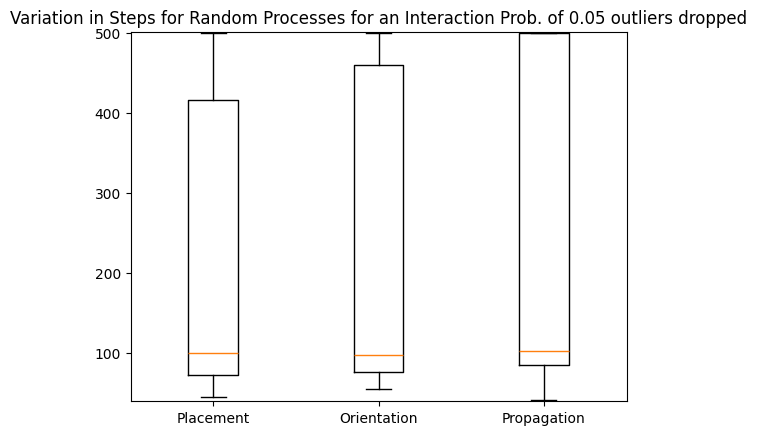

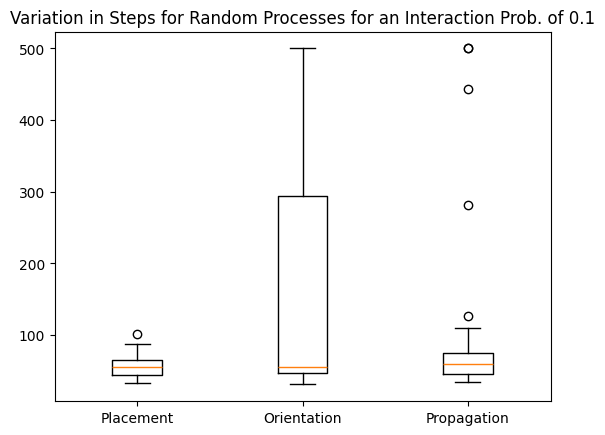

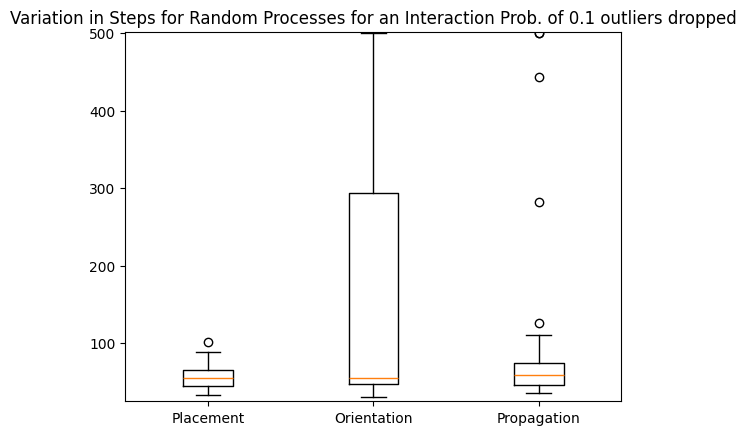

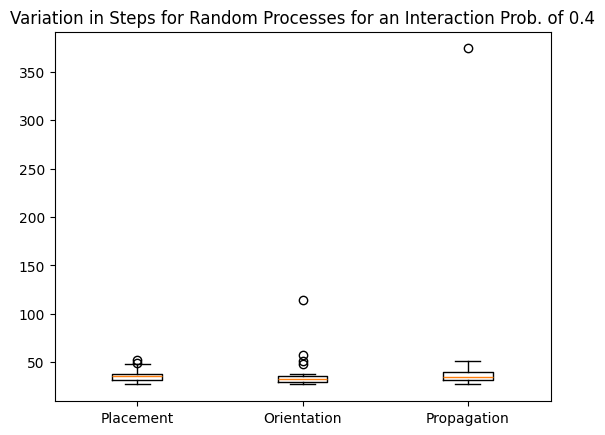

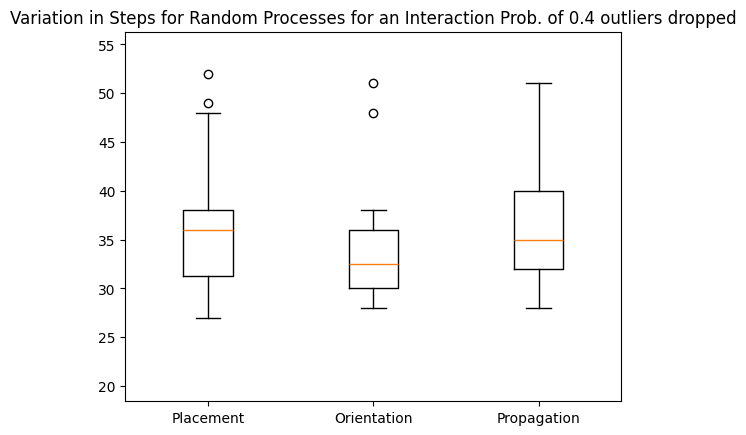

In [4]:
data_placement = pd.DataFrame(results_placement)[['interact_moore', 'Step']].round(decimals=2)
data_orientation = pd.DataFrame(results_orientation)[['interact_moore','Step']].round(decimals=2)
data_propagate = pd.DataFrame(results_propagate)[['interact_moore','Step']].round(decimals=2)

# depending on the type of figure you're going to generate, the data may need to be organised differently!
data_placement['RNG']='Placement'
data_orientation['RNG']='Orientation'
data_propagate['RNG']='Propagation'
datas = pd.concat([data_placement, data_orientation, data_propagate], axis=0)

plotBoxplot(datas[datas['interact_moore'] == 0.05].drop(['interact_moore'], axis=1),
            title = "Variation in Steps for Random Processes for an Interaction Prob. of 0.05", showfliers=False)
plotBoxplot(datas[datas['interact_moore'] == 0.1].drop(['interact_moore'], axis=1),
            title = "Variation in Steps for Random Processes for an Interaction Prob. of 0.1", showfliers=False)
plotBoxplot(datas[datas['interact_moore'] == 0.4].drop(['interact_moore'], axis=1),
            title = "Variation in Steps for Random Processes for an Interaction Prob. of 0.4", showfliers=False)

**Describe your findings here (max. 200 words)**
- Interaction probability: 
    - 0.05: no outliers, big value ranges (especially high numbers above mean), all features have similar boxplot shapes
    - 0.1: Placement and propagation have similar boxplot shapes, which have also outliers and their variation around their mean seems similar. The orientation has a different boxplot shape, which is similar to those of the 0.05 boxplots and has no outliers. 
    - 0.4: There are outliers. The boxplot value ranges are small and the variation around the mean is small. The boxplot shapes are similar to each other and the mean values are similar.

# impact of random processes
- small interaction probability: 
    - big impact of random processes
    - big value ranges
    - agents do not interact on their own and evacuate slower 
    - agents only interact with each other if they are close to each other and see each other all the time, which is strongly dependent on random processes (position, orientation, etc.)
- big interaction probability:
    - small impact of random processes
    - small value ranges
    - independent of random processes, agents will always interact and evacuate faster

## outliers
- small interaction probability:
    - no outliers
    - value range is big and thus, extreme values are not outliers but considered as normal values
- big interaction probability:
    - there are outliers
    - value range is small and thus, extreme values are considered as outliers

## Subtask 3 (Contingency)

Contingency means the dependence of random processes on the context. Find two stochastic processes in the evacuation model that can be modelled with contingency. Provide pseudo code for each of the processes that introduces contingency. Argue for your approach!


| Property | Probability |
|----------|-------------|
| adult    | high        |
| child    | low         |


**Write your answer here (200 words max. and pseudo code)!**

# 1. stochastic process: interaction probability
- shy people (agent property) are less likely to interact with others
- Hemmschwelle: value to compare generated random number with

Pseudo code:
```python

def interaction_probability(agent):
    # initialize Hemmschwelle
    if agent.shy:
        Hemmschwelle = random(0.5, 1)
    else:
        Hemmschwelle = random(0, 0.5)

    # ... more code ...
    # compare random number with Hemmschwelle
    if random() < Hemmschwelle:
        return True
    else:
        return False
```
Contengency is represented by if case.

# 2. stochastic process: orientation
- context: environment (context) -> don't turn to wall

Pseudo code:
```python

def orientation(agent):
    if agent.faces_position == wall:    # agent faces a wall
        # agent is not allowed to turn to the wall
        agent.orientation = random(90, 270)
    else:   # all directions are possible
        agent.orientation = random(0, 360)
```
Contengency is represented by if case.

# Argue for your approach
- Contingency is important to model real-world scenarios
- Contingency can be used to model that random processes can depend on the context or an agent's properties
- Contengency is represented by if cases in the pseudo code
I gave an example for both a property-dependent and a context-dependent stochastic process.
They are realistic, since a person's shyness can affect their interaction probability and the environment can affect the orientation of a person (a calm and rational person would avoid simply facing/ moving towards walls if the person's goal is to escape the room).

## Subtask 4 (Random to deterministic)

If one wants to avoid random numbers in the evacuation model, how could the propagation of information (alarm situation) be modeled in more detail without random processes? Provide pseudo code! What are the advantages and disadvantages of such an approach?

Are there other processes that could be modelled deterministic and detailed instead of randomly? Consider the three reasons for random processes!

**Write your anwser here (300 words max. and pseudo code)**

# Deterministic approach for information propagation
- deterministic approach: information propagation is based on  
    - the distance between agents and 
    - the realibility of the source of information
    - 'Wissensdurst' of receiver
```python
def information_propagation(agent, source): # Hemmschwelle in Matrix
    # high distance -> low probability of information propagation
    distance = sigmoid(calculate_distance(agent, source))   # sigmoid function to get a value between 0 and 1
    realibility = source.realibility    # high realibility -> high probability of information propagation
    if receiver.wissensdurst >= np.max(0, distance - realibility):
        return True # information is propagated
    else:
        return False # information is not propagated
```

# Advantages and disadvantages of deterministic approach in general
- Advantages:
    - deterministic approach is more predictable
    - deterministic approach is more reliable
    - deterministic approach is more understandable (less work to interpret results)

- Disadvantages:
    - deterministic approach is more complex to implement
    - deterministic approach is more time-consuming depending on the complexity of the model (# variables, # agents, etc.)
    - deterministic approach is only (if correctly implemented) the mean if uncertainty is involved
    - deterministic approach is not able to model variability, confidence intervals, etc.
    - results depend on the model and the assumptions made (initial conditions, etc.)

# Advantages and disadvantages of deterministic approach in particular (information propagation)
- Advantages:
    - deterministic approach is simplified
    - deterministic approach: clear rules for information propagation and which properties influence the propagation

- Disadvantages:
    - deterministic approach: no confidence intervals
    - deterministic approach: simplification of reality



# other processes that could be modelled deterministic and detailed instead of randomly
- orientation: deterministic approach based on rules (clockwise, counterclockwise, etc.)
    -> model looses modeling of **uncertainty** and variability in **exploration** (-> random processes would be better)
- placement: deterministic approach based on rules (place agents in the middle of the room, or in an order)
    -> unrealistic, because we can model only this scenario (-> random processes would be better)

# Task 3 (Diffusion: System Dynamics Version of SI Model)

-> See worksheet

cf. IntroABM_E09-task3-1_GutekunstKlara_2024-06-28.ipynb